# Data-Synthetic Misfit

`Pyatoa` provides functionality to address misfit quantification within a seismic tomography workflow. Operations include: seismic data gathering, waveform time-windowing, adjoint source creation, data storage, and measurement aggregation. In this Quickstart page, we demonstrate the capabilities of `Pyatoa` by collecting and processing seismic data. For more in-depth descriptions and tutorials, see the other pages in this documentation page, as well as the Pyatoa API.

### A New Zealand example
To illustrate functionality, we need to use a real earthquake and its recorded seismic waveforms. For the purposes of this tutorial, we'll be using the [M6.2 Eketahuna earthquake](https://www.geonet.org.nz/earthquake/story/2014p051675) that occurred in New Zealand in 2014. For this event, seismic waveform data was collected by the broadband seismic network of New Zealand [(GeoNet)](https://www.geonet.org.nz/data/network/sensor/search). We begin with imports of some of Pyatoa's core classes, and set the logging to be verbose using the DEBUG option.

In [1]:
from pyasdf import ASDFDataSet
from pyatoa import logger, Config, Manager, Inspector
logger.setLevel("DEBUG")

The `ASDFDataSet` is used for storage of seismic data. It is preferable to name the dataset after a unique event identifier.

In [2]:
event_id = "2018p130600"  # this is the unique GeoNet ID for the Eketahuna event
dataset_fid = f"../tests/test_data/{event_id}.h5"  # it is preferable to name the dataset after the event id
ds = ASDFDataSet(dataset_fid)

The Pyatoa `Config` object contains parameters which control the misfit quantification workflow. Since `Pyatoa` was designed to be used within seismic inversion tools, `iteration` and `step_count` attributes are available to keep track of where in the inversion we are. Let's say this is the beginning of the inversion, so the first iteration and the zeroth step count.  

We also choose some preset parameters for our preprocessing, time windowing and adjoint source generation algorithms.

In [3]:
cfg = Config(iteration=1, step_count=0, 
             event_id=event_id,
             client="GEONET",
             min_period=10, 
             max_period=30,
             start_pad=20,
             end_pad=200,
             pyflex_preset="nznorth_10-30s", 
             adj_src_type="cc_traveltime_misfit",
             )

[2022-02-28 10:29:14] - pyatoa - DEBUG: Component list set to E/N/Z


Finally, the `Manager` class is instantiated. The `Manager` is responsible for gathering, processing and storing data. It uses its `config` attribute to control the gathering and processing, and stores data to the `ASDFDataSet`.

In [4]:
mgmt = Manager(config=cfg, ds=ds)

### Gathering metadata and observed waveforms

First we need event metadata for this earthquake. Since we are working in the New Zealand domain, a moment tensor will automatically be appended from the GeoNet moment tensor catalog. 

> **__NOTE:__** Moment tensors are only available from the GeoNet moment tensor catalog, and from the Global Centroid Moment Tensor catalog.

In [5]:
mgmt.gather(choice="event")

[2022-02-28 10:29:15] - pyatoa - DEBUG: gathering event
[2022-02-28 10:29:15] - pyatoa - INFO: searching ASDFDataSet for event info
[2022-02-28 10:29:15] - pyatoa - DEBUG: matching event found: 2018p130600


Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:local/cmtsolution/2018p130600/event
    station   [inv]:       None
    observed  [st_obs]:    None
    synthetic [st_syn]:    None
Stats & Status
    half_dur:              0.0
    time_offset_sec:       None
    standardized:          False
    obs_processed:         False
    syn_processed:         False
    nwin   [windows]:      None
    misfit [adjsrcs]:      None

In [6]:
mgmt.event

Event:	2018-02-18T07:43:48.130000Z | -39.949, +176.299 | 4.86 mw

	                  resource_id: ResourceIdentifier(id="smi:local/cmtsolution/2018p130600/event")
	                   event_type: 'earthquake'
	          preferred_origin_id: ResourceIdentifier(id="smi:local/cmtsolution/2018p130600/origin#cmt")
	       preferred_magnitude_id: ResourceIdentifier(id="smi:local/cmtsolution/2018p130600/magnitude#mw")
	 preferred_focal_mechanism_id: ResourceIdentifier(id="smi:local/cmtsolution/2018p130600/focal_mechanism")
	                         ---------
	           event_descriptions: 1 Elements
	                     comments: 1 Elements
	             focal_mechanisms: 1 Elements
	                      origins: 2 Elements
	                   magnitudes: 3 Elements

With event information, we can now gather observation waveforms and station metadata. We will choose the station [NZ.WEL](https://www.geonet.org.nz/data/network/sensor/WEL), located in Wellington, New Zealand. We can use wildcards in the channel code to gather all available components, which are N, E and Z. Under the hood, Pyatoa is calling the ObsPy FDSN webservice client.

In [7]:
mgmt.gather(code="NZ.WEL.??.HH?", choice=["inv", "st_obs"])

[2022-02-28 10:29:15] - pyatoa - INFO: gathering data for NZ.WEL.??.HH?
[2022-02-28 10:29:15] - pyatoa - INFO: gathering observed waveforms
[2022-02-28 10:29:15] - pyatoa - INFO: searching ASDFDataSet for observations
[2022-02-28 10:29:15] - pyatoa - INFO: matching observed waveforms found
[2022-02-28 10:29:15] - pyatoa - INFO: gathering StationXML
[2022-02-28 10:29:15] - pyatoa - INFO: searching ASDFDataSet for station info
[2022-02-28 10:29:15] - pyatoa - INFO: matching StationXML found
[2022-02-28 10:29:15] - pyatoa - INFO: saved to ASDFDataSet


Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:local/cmtsolution/2018p130600/event
    station   [inv]:       NZ.WEL
    observed  [st_obs]:    3
    synthetic [st_syn]:    None
Stats & Status
    half_dur:              0.0
    time_offset_sec:       None
    standardized:          False
    obs_processed:         False
    syn_processed:         False
    nwin   [windows]:      None
    misfit [adjsrcs]:      None

In [8]:
mgmt.inv

Inventory created at 2022-02-27T20:54:58.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (1):
			NZ.WEL (Wellington)
		Channels (3):
			NZ.WEL.10.HHZ, NZ.WEL.10.HHN, NZ.WEL.10.HHE

In [9]:
# mgmt.st_obs = st_obs
mgmt.st_obs

3 Trace(s) in Stream:
NZ.WEL.10.HHE | 2018-02-18T07:43:28.133092Z - 2018-02-18T07:47:08.133092Z | 100.0 Hz, 22001 samples
NZ.WEL.10.HHN | 2018-02-18T07:43:28.133092Z - 2018-02-18T07:47:08.133092Z | 100.0 Hz, 22001 samples
NZ.WEL.10.HHZ | 2018-02-18T07:43:28.133091Z - 2018-02-18T07:47:08.133091Z | 100.0 Hz, 22001 samples

### Creating synthetic waveforms

Unfortunately we can't easily gather synthetic data (st_syn), as this needs to be generated using an external numerical solver. For the sake of this tutorial, we'll simply shift the phase and scale the amplitude of our observed data to create our "synthetic" data.

In [10]:
def generate_synthetic_data(st, shift_sec=4, multiply_amp=0.8, 
                            tail_taper_pct=0.5):
    """
    Generate synthetic data using observed data by shifting waveform
    then padding zeros.
    
    :type shift_sec: float
    :param shift_sec: the number of seconds to shift data by
    """
    import numpy as np

    st = st.copy()
    
    # First we need to remove instrument response because Pyatoa wont
    # do that for synthetic traces
    st.detrend("linear").detrend("demean").taper(0.05)
    st.remove_response(inventory=mgmt.inv, output="DISP")
    
    for tr in st:
        # Time delay the waveform by a certain number of seconds
        num_samples = int(tr.stats.sampling_rate * shift_sec)
        tr.data = np.concatenate([np.zeros(num_samples), tr.data[:-num_samples]])
        
        # Multiply amplitudes by some percentage
        tr.data *= multiply_amp
        
        # Taper ends to make data look more 'synthetic'
        tr.taper(tail_taper_pct, side="both")
        
        # Change the channel naming for clarity
        cha = tr.stats.channel
        tr.stats.channel = f"{cha[0]}X{cha[2]}"

    return st

mgmt.st_syn = generate_synthetic_data(mgmt.st_obs)

Now we can standardize and preprocess our waveforms. Standardization involves matching the time series of the observation and synthetic waveforms. Preprocessing involves instrument response removal and frequency domain filtering.

In [11]:
mgmt.standardize().preprocess()

[2022-02-28 10:29:15] - pyatoa - INFO: standardizing streams
[2022-02-28 10:29:15] - pyatoa - DEBUG: start and endtimes already match to 0.001
[2022-02-28 10:29:15] - pyatoa - DEBUG: time offset is -19.996908s
[2022-02-28 10:29:15] - pyatoa - INFO: preprocessing observation data
[2022-02-28 10:29:15] - pyatoa - INFO: adjusting taper to cover time offset -19.996908
[2022-02-28 10:29:15] - pyatoa - DEBUG: removing response, units to DISP
[2022-02-28 10:29:15] - pyatoa - DEBUG: rotating from generic coordinate system to ZNE
[2022-02-28 10:29:15] - pyatoa - DEBUG: bandpass filter: 10.0 - 30.0s w/ 2.0 corners
[2022-02-28 10:29:15] - pyatoa - INFO: preprocessing synthetic data
[2022-02-28 10:29:15] - pyatoa - INFO: adjusting taper to cover time offset -19.996908
[2022-02-28 10:29:15] - pyatoa - DEBUG: no response removal, synthetic data or requested not to
[2022-02-28 10:29:15] - pyatoa - DEBUG: bandpass filter: 10.0 - 30.0s w/ 2.0 corners


Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:local/cmtsolution/2018p130600/event
    station   [inv]:       NZ.WEL
    observed  [st_obs]:    3
    synthetic [st_syn]:    3
Stats & Status
    half_dur:              0.0
    time_offset_sec:       -19.996908
    standardized:          True
    obs_processed:         True
    syn_processed:         True
    nwin   [windows]:      None
    misfit [adjsrcs]:      None

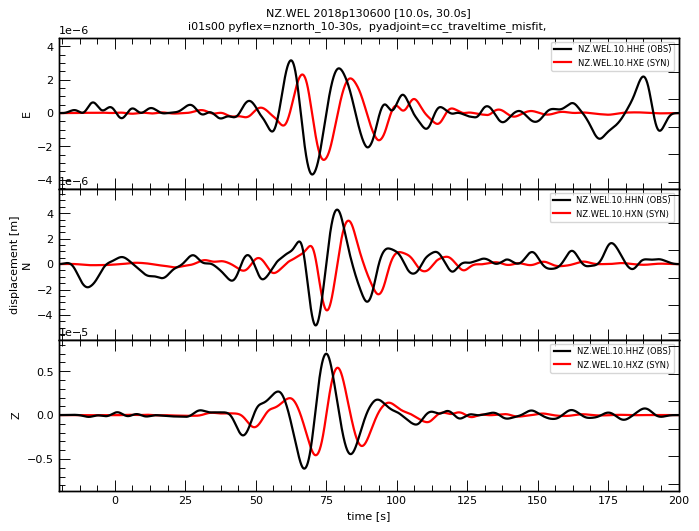

In [12]:
mgmt.plot(choice="wav")

### Time windowing 

Great, now that we have similar looking waveforms, we can use `Pyflex` to generate time windows in which the two waveforms are in good agreement.

In [13]:
mgmt.window()

[2022-02-28 10:29:15] - pyatoa - INFO: running Pyflex w/ map: nznorth_10-30s
[2022-02-28 10:29:16] - pyatoa - INFO: 1 window(s) selected for comp E
[2022-02-28 10:29:16] - pyatoa - INFO: 1 window(s) selected for comp N
[2022-02-28 10:29:16] - pyatoa - INFO: 1 window(s) selected for comp Z
[2022-02-28 10:29:16] - pyatoa - DEBUG: saving misfit windows to ASDFDataSet
[2022-02-28 10:29:16] - pyatoa - INFO: 3 window(s) total found


Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:local/cmtsolution/2018p130600/event
    station   [inv]:       NZ.WEL
    observed  [st_obs]:    3
    synthetic [st_syn]:    3
Stats & Status
    half_dur:              0.0
    time_offset_sec:       -19.996908
    standardized:          True
    obs_processed:         True
    syn_processed:         True
    nwin   [windows]:      3
    misfit [adjsrcs]:      None

In [14]:
mgmt.windows

{'E': [Window(left=4440, right=12487, center=8463, channel_id=NZ.WEL.10.HHE, max_cc_value=0.9874679817515194, cc_shift=-401, dlnA=0.28778062445774544)],
 'N': [Window(left=4440, right=13755, center=9097, channel_id=NZ.WEL.10.HHN, max_cc_value=0.9882763627416445, cc_shift=-400, dlnA=0.27103148126016535)],
 'Z': [Window(left=4440, right=14266, center=9353, channel_id=NZ.WEL.10.HHZ, max_cc_value=0.9980045265746181, cc_shift=-403, dlnA=0.2803855536521639)]}

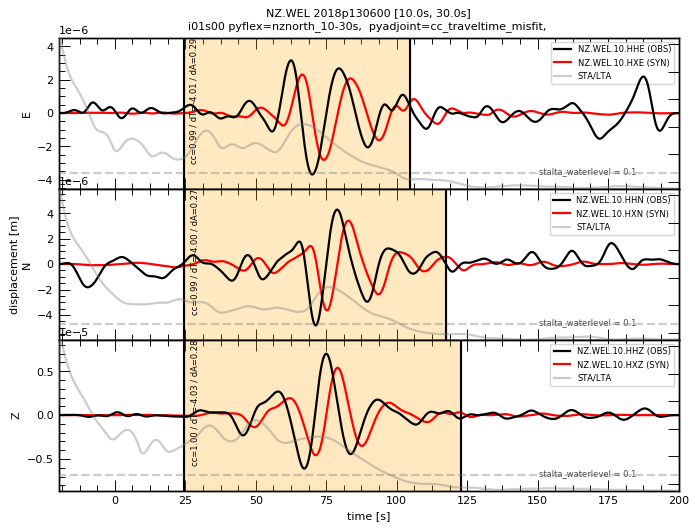

In [15]:
mgmt.plot(choice="wav")

### Adjoint source creation
Now we can use `Pyadjoint` to calculate the misfit and generate adjoint sources within each of these time windows.

In [16]:
mgmt.measure()

[2022-02-28 10:29:17] - pyatoa - DEBUG: running Pyadjoint w/ type: cc_traveltime_misfit
[2022-02-28 10:29:17] - pyatoa - INFO: 8.040 misfit for comp E
[2022-02-28 10:29:17] - pyatoa - INFO: 8.000 misfit for comp N
[2022-02-28 10:29:17] - pyatoa - INFO: 8.120 misfit for comp Z
[2022-02-28 10:29:17] - pyatoa - DEBUG: saving adjoint sources to ASDFDataSet
[2022-02-28 10:29:17] - pyatoa - INFO: total misfit 24.161


Manager Data
    dataset   [ds]:        2018p130600.h5
    quakeml   [event]:     smi:local/cmtsolution/2018p130600/event
    station   [inv]:       NZ.WEL
    observed  [st_obs]:    3
    synthetic [st_syn]:    3
Stats & Status
    half_dur:              0.0
    time_offset_sec:       -19.996908
    standardized:          True
    obs_processed:         True
    syn_processed:         True
    nwin   [windows]:      3
    misfit [adjsrcs]:      24.160500000000003

In [17]:
mgmt.adjsrcs

{'E': <pyadjoint.adjoint_source.AdjointSource at 0x7f4c711ff450>,
 'N': <pyadjoint.adjoint_source.AdjointSource at 0x7f4c4c5a3710>,
 'Z': <pyadjoint.adjoint_source.AdjointSource at 0x7f4c4c5a3850>}

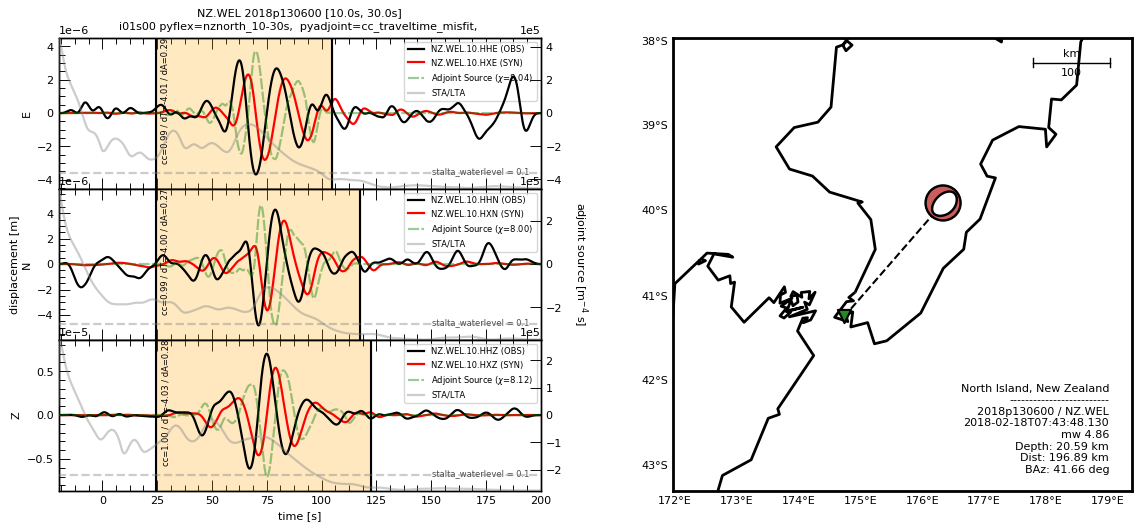

In [18]:
mgmt.plot(choice="both")

### Stored data

All the data that we have collected during this workflow is stored in the `ASDFDataSet`. We can access it by querying the data set itself, or by re-loading data using the `Manager` class. See the other tutorials for more information about these features.

In [19]:
ds

ASDF file [format version: 1.0.3]: '../tests/test_data/2018p130600.h5' (718.5 KB)
	Contains 1 event(s)
	Contains waveform data from 2 station(s).
	Contains 3 type(s) of auxiliary data: AdjointSources, Configs, MisfitWindows

In [20]:
ds.waveforms.NZ_WEL

Contents of the data set for station NZ.WEL:
    - Has a StationXML file
    - 1 Waveform Tag(s):
        observed

In [21]:
ds.auxiliary_data.MisfitWindows.i01.s00

6 auxiliary data item(s) of type 'MisfitWindows/i01/s00' available:
	NZ_BFZ_E_0
	NZ_BFZ_N_0
	NZ_BFZ_Z_0
	NZ_WEL_E_0
	NZ_WEL_N_0
	NZ_WEL_Z_0

In [22]:
ds.auxiliary_data.AdjointSources.i01.s00

6 auxiliary data item(s) of type 'AdjointSources/i01/s00' available:
	NZ_BFZ_BXE
	NZ_BFZ_BXN
	NZ_BFZ_BXZ
	NZ_WEL_HXE
	NZ_WEL_HXN
	NZ_WEL_HXZ

Further capabilities for measurement aggregation are contained in the `Inspector` class, which has its own tutorial. Hopefully this initial quickstart has provided some introiduction to the capabilities of the `Pyatoa` package!